In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('train.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
import re

In [9]:
def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

df.tweet = df.tweet.apply(clean)

In [10]:
df

,id,label,tweet
0,1,0,when a father is dysfunctional and is so se...
1,2,0,thanks for lyft credit i can t use cause ...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in ...
4,5,0,factsguide society now motivation
...,...,...,...
31957,31958,0,ate isz that youuu
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,sikh temple vandalised in in calgary ws...


<AxesSubplot:>

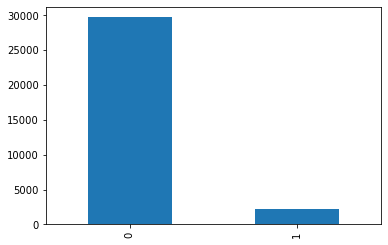

In [11]:
df['label'].value_counts().plot(kind='bar')

In [12]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(31962, 512)

In [13]:
from transformers import BertTokenizer

In [14]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [15]:
# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['tweet'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [16]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
tokens['input_ids']

array([[  101,  1165,   170, ...,     0,     0,     0],
       [  101,  5438,  1111, ...,     0,     0,     0],
       [  101, 16516,  1324, ...,     0,     0,     0],
       ...,
       [  101,  5578,  1106, ...,     0,     0,     0],
       [  101, 27466,  9862, ...,     0,     0,     0],
       [  101,  6243,  1128, ...,     0,     0,     0]])

In [18]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [19]:
import numpy as np

In [20]:
with open('tweets_xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('tweets_xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [21]:
del tokens

In [22]:
arr = df['label'].values
arr, arr.shape

(array([0, 0, 0, ..., 0, 1, 0], dtype=int64), (31962,))

In [23]:
arr.max()+1

2

In [24]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(31962, 2)

In [25]:
labels[np.arange(num_samples),arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [26]:
with open('tweets_labels.npy', 'wb') as f:
    np.save(f, labels)

In [27]:
with open('tweets_xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweets_xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweets_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [28]:
Xids.shape

(31962, 512)

In [29]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [30]:
import tensorflow as tf

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [32]:
def map_funct(ids, mask, labels):
    return {'input_ids': ids, 'attention_mask':mask},labels

dataset = dataset.map(map_funct)

In [33]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [34]:
batch_size = 3

dataset = dataset.shuffle(3000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [35]:
#Split training and validation set
split = 0.9

In [36]:
size = int((Xids.shape[0] / batch_size) * split)
size

9588

In [37]:
train_set = dataset.take(size)
val_set = dataset.skip(size)

del dataset

In [38]:
train_set

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [39]:
tf.data.experimental.save(train_set, 'train')
tf.data.experimental.save(val_set, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [40]:
train_set.element_spec

({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))

In [41]:
val_set.element_spec == train_set.element_spec

True

In [42]:
ds = tf.data.experimental.load('train', element_spec=train_set.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [43]:
from transformers import TFAutoModel

In [44]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [45]:
# we can view the model using the summary method
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [46]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

In [47]:
# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

In [48]:
# convert bert embeddings into 2 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(2, activation='relu')(x)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

In [49]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [50]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [51]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))
                
# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [1]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

NameError: name 'model' is not defined

In [ ]:
model.save('sentiment_model')

In [ ]:
model = tf.keras.models.load_model('sentiment_model')

# view model architecture to confirm we have save and loaded correctly
model.summary()

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask']}

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

dfa = pd.read_csv('test.csv')
dfa.head()

In [ ]:
import re

In [ ]:
def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

dfa.tweet = dfa.tweet.apply(clean)

In [ ]:
dfa

In [ ]:
dfa['Label'] = None

for i, row in dfa.iterrows():
    # get token tensors
    tokens = prep_data(row['tweet'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    dfa.at[i, 'Label'] = pred

dfa.head()